In [1]:
from pathlib import Path
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

from patchify import patchify, unpatchify
from src.lightningmodule import SegmentationModule

In [2]:
SCENES = Path.cwd().parent / "datasets" / "inria" / "train" / "images"
MASKS = Path.cwd().parent / "datasets" / "inria" / "train" / "gt"
CHECKPOINTS = Path.cwd() / "checkpoints"

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


### Load Model

In [3]:
checkpoint_path = next(CHECKPOINTS.iterdir())
checkpoint = torch.load(checkpoint_path)
unet = smp.Unet("resnet18") 
preprocess = get_preprocessing_fn("resnet18")
model = SegmentationModule(unet, preprocess,
                           loss = "dice",
                           learning_rate = 3e-4,
                           batch_size = 4)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [4]:
def load_raster(raster_path):
    with rio.open(raster_path) as raster:
        return raster.read()

### Idea 1: Inference on Entire Scene

In [24]:
scene_path = next(SCENES.iterdir())
mask_path = next(MASKS.iterdir())

scene = torch.from_numpy(load_raster(scene_path)).to(torch.float)
mask = torch.from_numpy(load_raster(mask_path)).to(torch.float)

In [25]:
size = (5000//32) * 32
resize = transforms.Resize(size = (size, size))

In [26]:
scene = resize(scene)
scene = scene.unsqueeze(dim = 0).to(DEVICE)

mask = resize(mask)
mask = mask.unsqueeze(dim = 0).to(DEVICE)

In [27]:
model.to(DEVICE)
print(model.device)

cuda:0


In [ ]:
model.eval()
model.forward(scene)

### Idea 2: Inference on Non-Overlapping Patches

In [18]:
raster_path = next(DATA.iterdir())
with rio.open(raster_path) as raster:
    scene = raster.read()

(-0.5, 4999.5, 4999.5, -0.5)

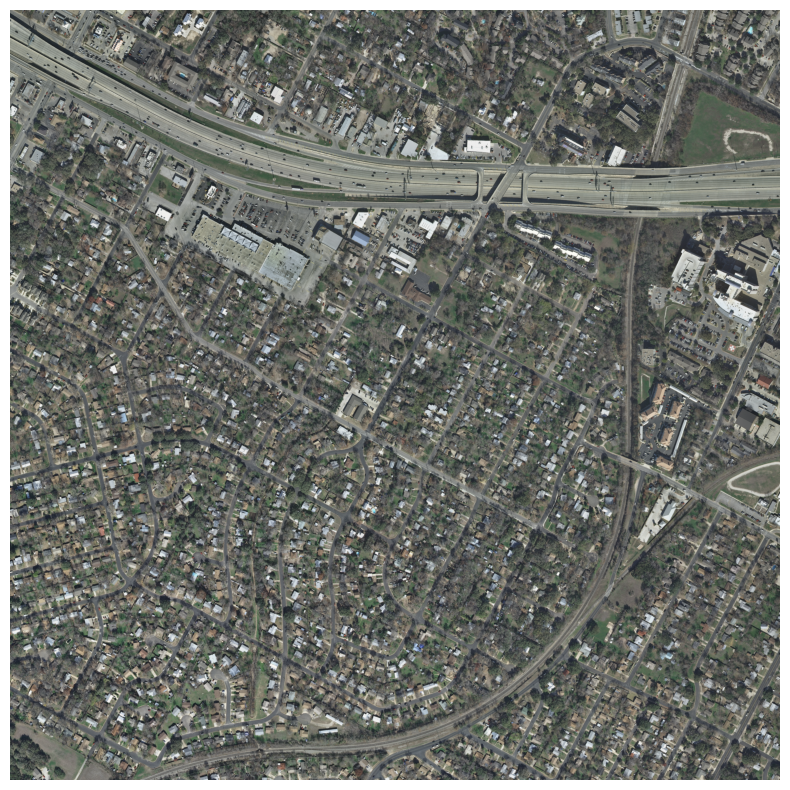

In [14]:
fig = plt.figure(figsize = (10, 10))
plt.imshow(scene.transpose(1, 2, 0))
plt.axis("off")

In [21]:
patches = patchify(scene.transpose(1, 2, 0), (512, 512, 3), step = 408)

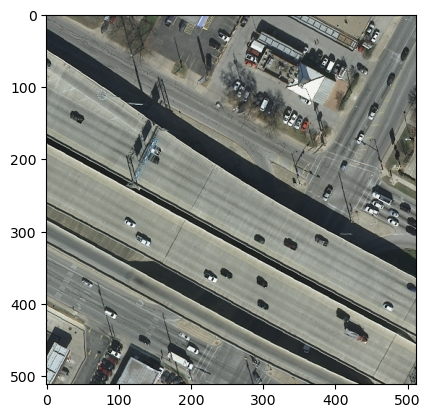

In [33]:
plt.imshow(patches.squeeze()[0, 0])

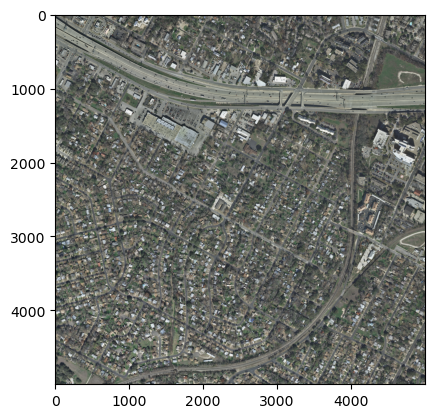

In [40]:
plt.imshow(unpatchify(patches, imsize = (5000, 5000, 3)))


In [2]:
BINARY_LOSS = "binary"
MULTICLASS_LOSS = "multiclass"

In [3]:
"binary" in {BINARY_LOSS, MULTICLASS_LOSS}

True